# Honest Inference for Event Study Plots

**Goal**: Assess and prototype honest inference features for `diff-diff` plotting, inspired by:

| Package | Approach | Key Innovation |
|---------|----------|----------------|
| [HonestDiD](https://github.com/asheshrambachan/HonestDiD) | Sensitivity analysis | CIs robust to parallel trends violations |
| [eventstudyr](https://github.com/JMSLab/eventstudyr) | Simultaneous inference | Sup-t bands + smoothest confounding path |
| [fdid](https://ccfang2.github.io/fdid/) | Functional DiD | SCBs for equivalence/relevance testing |

**Key papers**:
- Rambachan & Roth (2023) — "A More Credible Approach to Parallel Trends"
- Freyaldenhoven, Hansen, Perez Perez, Shapiro (2021) — "Visualization, Identification, and Estimation in the Linear Panel Event-Study Design" (NBER w29170)
- Roth (2026) — "Interpreting Event-Studies from Recent Difference-in-Differences Methods"
- Fang & Liebl (2026) — "Functional Difference-in-Differences" (fdid)

---

## Table of Contents

1. [Setup & Data](#1-setup--data)
2. [What `diff-diff` Already Has: HonestDiD](#2-what-diff-diff-already-has-honestdid)
3. [Gap 1: Simultaneous Confidence Bands (eventstudyr)](#3-gap-1-simultaneous-confidence-bands)
4. [Gap 2: Smoothest Confounding Path (eventstudyr)](#4-gap-2-smoothest-confounding-path)
5. [Gap 3: Functional SCBs (fdid)](#5-gap-3-functional-scbs)
6. [Insights from the Papers](#6-insights-from-the-papers)
7. [Compatibility Assessment](#7-compatibility-assessment)
8. [Prototypes](#8-prototypes)
9. [Multi-Model Comparison Fairness](#9-multi-model-comparison-fairness)
10. [Freyaldenhoven et al. Plot Features](#10-freyaldenhoven-et-al-plot-features)
11. [Comprehensive Roadmap](#11-comprehensive-roadmap)

## 1. Setup & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats as scipy_stats
from scipy.optimize import minimize, linprog

from diff_diff import (
    MultiPeriodDiD,
    CallawaySantAnna,
    generate_did_data,
    load_mpdta,
    plot_event_study,
)

# HonestDiD from diff-diff
from diff_diff import HonestDiD
from diff_diff.honest_did import SensitivityResults, HonestDiDResults
from diff_diff.visualization import plot_sensitivity, plot_honest_event_study

import warnings
warnings.filterwarnings('ignore')

print('All imports successful')

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


All imports successful


In [2]:
# Generate panel data
data = generate_did_data(
    n_units=200, n_periods=10, treatment_effect=5.0,
    treatment_fraction=0.5, treatment_period=5, seed=42
)

# Multi-period DiD
mp_did = MultiPeriodDiD(alpha=0.05)
mp_results = mp_did.fit(
    data, outcome='outcome', treatment='treated',
    time='period', post_periods=list(range(5, 10)),
)
print(f'ATT = {mp_results.avg_att:.3f} (SE = {mp_results.avg_se:.3f})')

# Also prepare staggered data
try:
    mpdta = load_mpdta()
    cs = CallawaySantAnna(control_group='never_treated', alpha=0.05)
    cs_results = cs.fit(
        mpdta, outcome='lemp', unit='countyreal',
        time='year', first_treat='first_treat', aggregate='event_study',
    )
    print(f'CS Overall ATT = {cs_results.overall_att:.4f}')
except Exception as e:
    print(f'CS failed: {e}')
    cs_results = None

# Synthetic event study data for plotting demos
np.random.seed(42)
periods = np.arange(-5, 6)
true_effect = np.where(periods >= 0, 3.0 + 0.3 * periods, 0)
noise = np.random.normal(0, 0.3, len(periods))
estimates = true_effect + noise
se_vals = np.abs(np.random.normal(0.4, 0.08, len(periods)))
# Set reference period to 0
estimates[periods == -1] = 0.0
se_vals[periods == -1] = 0.0

es_df = pd.DataFrame({
    'period': periods,
    'estimate': estimates,
    'se': se_vals,
})

print(f'Synthetic ES data: {len(es_df)} periods')
es_df

ATT = 4.977 (SE = 0.292)
CS Overall ATT = -0.0214
Synthetic ES data: 11 periods


,period,estimate,se
0,-5,0.149014,0.362742
1,-4,-0.041479,0.419357
2,-3,0.194307,0.246938
3,-2,0.456909,0.262007
4,-1,0.000000,0.000000
5,0,2.929759,0.318974
6,1,3.773764,0.425140
7,2,3.830230,0.327358
8,3,3.759158,0.287016
9,4,4.362768,0.517252


## 2. What `diff-diff` Already Has: HonestDiD

`diff-diff` already implements the core of Rambachan & Roth (2023):

| Feature | Status | Function |
|---------|--------|----------|
| Smoothness restriction ($\Delta^{SD}$) | Available | `HonestDiD(method='smoothness')` |
| Relative magnitude ($\Delta^{RM}$) | Available | `HonestDiD(method='relative_magnitude')` |
| Combined ($\Delta^{SDRM}$) | Available | `HonestDiD(method='combined')` |
| Sensitivity analysis | Available | `HonestDiD.sensitivity_analysis()` |
| Breakdown value | Available | `HonestDiD.breakdown_value()` |
| Sensitivity plot | Available | `plot_sensitivity()` |
| Honest event study plot | Available | `plot_honest_event_study()` |

Let's demo these existing functions.

In [3]:
# HonestDiD with relative magnitude restriction
honest = HonestDiD(method='relative_magnitude', M=1.0, alpha=0.05)
honest_results = honest.fit(mp_results)

print('=== HonestDiD Results (Relative Magnitude, M=1.0) ===')
honest_results.print_summary()

=== HonestDiD Results (Relative Magnitude, M=1.0) ===
               Honest DiD Sensitivity Analysis Results                
                       (Rambachan & Roth 2023)                        

Method:                        Relative Magnitudes (Delta^RM)
Restriction parameter (M):     1.0000
CI method:                     C-LF

----------------------------------------------------------------------
              Original Estimate (under parallel trends)               
----------------------------------------------------------------------
Point estimate:                4.9771
Standard error:                0.2918

----------------------------------------------------------------------
               Robust Results (allowing for violations)               
----------------------------------------------------------------------
Identified set:                [4.7673, 5.1868]
95% Robust CI:                 [4.1955, 5.7587]

Effect robust to violations:   Yes

------------------------------

In [4]:
# Sensitivity analysis
sens_results = honest.sensitivity_analysis(mp_results)
sens_results.print_summary()

# Breakdown value
bd = honest.breakdown_value(mp_results)
print(f'\nBreakdown value: {bd}')

                   Honest DiD Sensitivity Analysis                    

Method:                        relative_magnitude
Original estimate:             4.9771
Original SE:                   0.2918
M values tested:               9

Breakdown value:               None (always significant)

----------------------------------------------------------------------
M           Lower Bound  Upper Bound     CI Lower     CI Upper
----------------------------------------------------------------------
0.0000           4.9771       4.9771       4.4052       5.5489
0.2500           4.9246       5.0295       4.3528       5.6014
0.5000           4.8722       5.0820       4.3004       5.6538
0.7500           4.8198       5.1344       4.2479       5.7062
1.0000           4.7673       5.1868       4.1955       5.7587
1.2500           4.7149       5.2393       4.1431       5.8111
1.5000           4.6625       5.2917       4.0906       5.8635
1.7500           4.6100       5.3441       4.0382       5.9160
2

ValueError: 'yerr' must not contain negative values

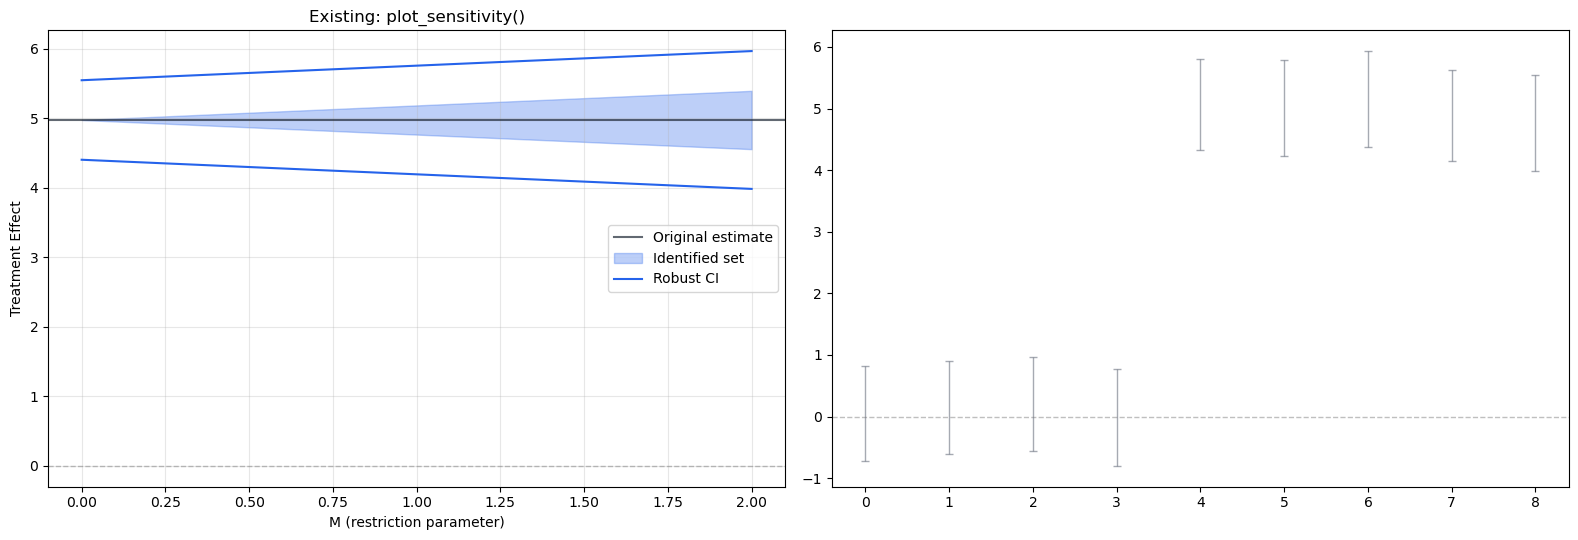

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

# Left: Sensitivity plot
plot_sensitivity(sens_results, ax=axes[0], show=False,
                 title='Existing: plot_sensitivity()')

# Right: Honest event study
plot_honest_event_study(honest_results, ax=axes[1], show=False,
                        title='Existing: plot_honest_event_study()')

plt.tight_layout()
plt.show()

**Assessment of existing HonestDiD support:**

- The core estimation is solid (smoothness, relative magnitude, combined restrictions)
- `plot_sensitivity()` shows how CIs widen as $\bar{M}$ increases — a *separate* diagnostic plot
- `plot_honest_event_study()` shows robust vs. standard CIs side-by-side on the event study

**What's missing:**
1. No **simultaneous confidence bands** (sup-t) — current CIs are pointwise
2. No **smoothest confounding path** overlay
3. No **functional SCBs** (equivalence/relevance testing)
4. No integration with the `ggiplot()` prototype from the plotting notebook
5. No way to overlay honest inference *inside* the main event study plot in a unified way

## 3. Gap 1: Simultaneous Confidence Bands (eventstudyr)

### The Problem with Pointwise CIs

Standard event study plots show **pointwise** 95% CIs: each period's CI has 95% coverage *individually*. But when viewing all periods together, the probability that *at least one* CI fails to cover the truth is much higher than 5%.

**eventstudyr** solves this with **sup-t simultaneous bands** (Montiel Olea & Plagborg-Moller, 2019):

$$\text{Simultaneous band} = \hat{\beta}_t \pm c_{\alpha}^{\text{sup-t}} \cdot \hat{\sigma}_t$$

where $c_{\alpha}^{\text{sup-t}}$ is the critical value from:

$$P\left(\max_t \left|\frac{\hat{\beta}_t - \beta_t}{\hat{\sigma}_t}\right| \leq c_{\alpha}^{\text{sup-t}}\right) = 1 - \alpha$$

This is computed via simulation from the multivariate normal distribution of the coefficient estimates using their variance-covariance matrix $\hat{\Sigma}$.

**Key insight**: sup-t bands are always **wider** than pointwise CIs. If the zero line is inside the sup-t band for all pre-treatment periods simultaneously, it provides much stronger evidence for parallel trends.

In [6]:
def compute_supt_critical_value(vcov, alpha=0.05, n_sim=10000, seed=42):
    """
    Compute the sup-t critical value for simultaneous confidence bands.
    
    Following Montiel Olea & Plagborg-Moller (2019).
    
    Parameters
    ----------
    vcov : array-like (K x K)
        Variance-covariance matrix of the K coefficients.
    alpha : float
        Significance level (default 0.05 for 95% bands).
    n_sim : int
        Number of simulations for computing the critical value.
    
    Returns
    -------
    c_supt : float
        Critical value such that P(max|Z_k/sigma_k| <= c_supt) = 1 - alpha.
    """
    rng = np.random.default_rng(seed)
    K = vcov.shape[0]
    sigma = np.sqrt(np.diag(vcov))
    
    # Draw from MVN(0, vcov)
    draws = rng.multivariate_normal(np.zeros(K), vcov, size=n_sim)
    
    # Standardize by sigma
    t_stats = np.abs(draws / sigma[np.newaxis, :])
    
    # Take the max over coefficients for each draw
    max_t = np.max(t_stats, axis=1)
    
    # Critical value is the (1-alpha) quantile
    c_supt = np.quantile(max_t, 1 - alpha)
    
    return c_supt


# Demo: compare pointwise vs sup-t critical values
K = 8  # 8 pre/post periods
rng = np.random.default_rng(42)

# Generate a realistic vcov (correlated coefficients)
A = rng.normal(0, 0.3, (K, K))
vcov = A @ A.T + 0.1 * np.eye(K)  # positive definite
sigma = np.sqrt(np.diag(vcov))

c_pointwise = scipy_stats.norm.ppf(0.975)  # 1.96
c_supt = compute_supt_critical_value(vcov, alpha=0.05)

print(f'Pointwise critical value (z_0.025): {c_pointwise:.3f}')
print(f'Sup-t critical value (K={K}):       {c_supt:.3f}')
print(f'Sup-t / Pointwise ratio:            {c_supt / c_pointwise:.2f}x wider')

Pointwise critical value (z_0.025): 1.960
Sup-t critical value (K=8):       2.701
Sup-t / Pointwise ratio:            1.38x wider


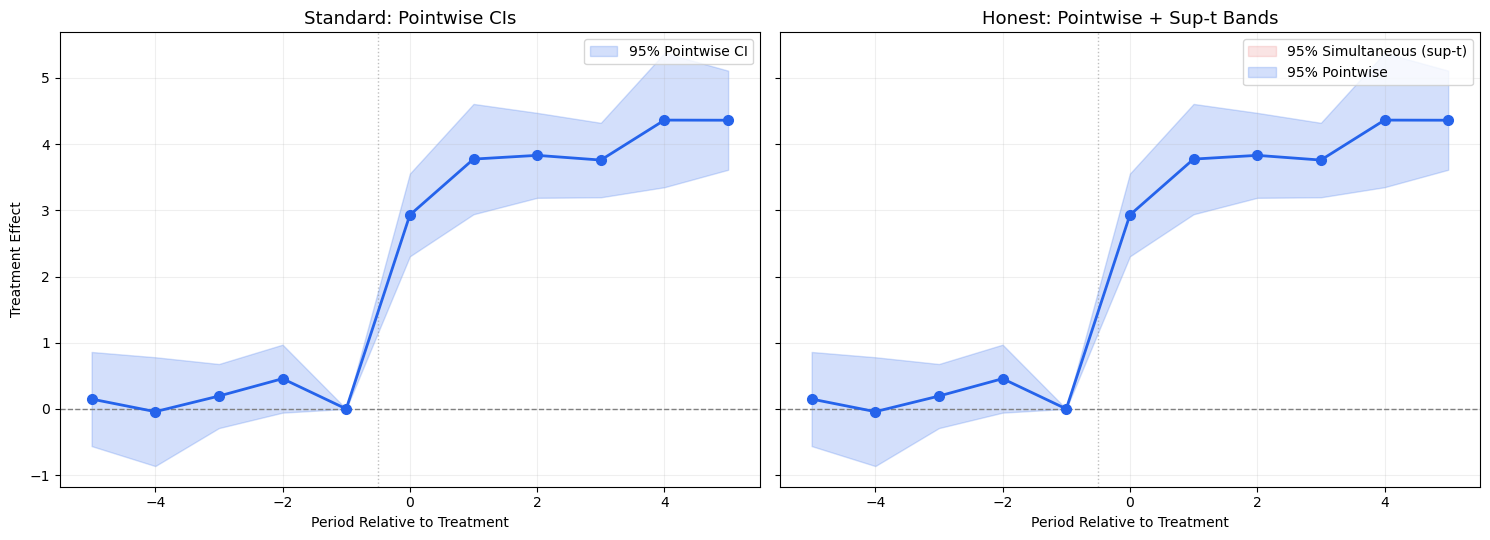


Sup-t bands are nanx wider than pointwise CIs
This accounts for multiple testing across all periods simultaneously


In [7]:
# Visual comparison: pointwise vs sup-t bands
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5), sharey=True)

periods_demo = es_df['period'].values
est_demo = es_df['estimate'].values
se_demo = es_df['se'].values

# Build a realistic vcov for our synthetic data
K_demo = len(periods_demo)
# Use a simple AR(1) correlation structure
rho = 0.5
corr = np.array([[rho**abs(i-j) for j in range(K_demo)] for i in range(K_demo)])
vcov_demo = np.outer(se_demo, se_demo) * corr

c_supt_demo = compute_supt_critical_value(vcov_demo, alpha=0.05)

# Left: pointwise CIs
ax = axes[0]
ci_low_pw = est_demo - 1.96 * se_demo
ci_high_pw = est_demo + 1.96 * se_demo
ax.fill_between(periods_demo, ci_low_pw, ci_high_pw, alpha=0.2, color='#2563eb', label='95% Pointwise CI')
ax.plot(periods_demo, est_demo, 'o-', color='#2563eb', markersize=7, linewidth=2, zorder=3)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_title('Standard: Pointwise CIs', fontsize=13)
ax.set_xlabel('Period Relative to Treatment')
ax.set_ylabel('Treatment Effect')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)

# Right: sup-t bands
ax = axes[1]
ci_low_supt = est_demo - c_supt_demo * se_demo
ci_high_supt = est_demo + c_supt_demo * se_demo
# Show pointwise as inner band
ax.fill_between(periods_demo, ci_low_supt, ci_high_supt, alpha=0.12, color='#dc2626', label='95% Simultaneous (sup-t)')
ax.fill_between(periods_demo, ci_low_pw, ci_high_pw, alpha=0.2, color='#2563eb', label='95% Pointwise')
ax.plot(periods_demo, est_demo, 'o-', color='#2563eb', markersize=7, linewidth=2, zorder=3)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_title('Honest: Pointwise + Sup-t Bands', fontsize=13)
ax.set_xlabel('Period Relative to Treatment')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f'\nSup-t bands are {c_supt_demo/1.96:.1f}x wider than pointwise CIs')
print('This accounts for multiple testing across all periods simultaneously')

## 4. Gap 2: Smoothest Confounding Path (eventstudyr)

### The Idea

From Freyaldenhoven et al. (2021), the **smoothest path** of confounding trend that is consistent with the estimated pre-treatment coefficients provides a visual benchmark. If the pre-treatment event study coefficients are indistinguishable from zero, this path shows what the "most conservative" violation of parallel trends could look like.

Formally, we solve:

$$\min_{\delta} \sum_{t} (\delta_{t+1} - 2\delta_t + \delta_{t-1})^2 \quad \text{s.t.} \quad \delta_{\text{pre}} \text{ consistent with data}$$

This gives the **smoothest** confound that could explain the pre-treatment pattern, which is then extrapolated post-treatment to show how much bias we might expect.

**eventstudyr** overlays this as a dashed line on the event study plot.

In [8]:
def compute_smoothest_path(pre_estimates, pre_periods, post_periods, ref_period=-1):
    """
    Compute the smoothest confounding path consistent with pre-treatment estimates.
    
    Minimizes the sum of squared second differences (curvature) of the path,
    subject to the path matching the pre-treatment estimates.
    
    Parameters
    ----------
    pre_estimates : array-like
        Estimated coefficients for pre-treatment periods (excluding reference).
    pre_periods : array-like
        Period indices for pre-treatment.
    post_periods : array-like
        Period indices for post-treatment (for extrapolation).
    ref_period : int
        The reference (normalized) period.
    
    Returns
    -------
    all_periods : array
        Combined pre + ref + post periods.
    smoothest : array
        The smoothest confounding path for all periods.
    """
    # All periods including reference
    all_periods = np.sort(np.concatenate([pre_periods, [ref_period], post_periods]))
    T = len(all_periods)
    
    # Reference period index
    ref_idx = np.where(all_periods == ref_period)[0][0]
    
    # Pre-period indices (excluding reference)
    pre_idx = [np.where(all_periods == p)[0][0] for p in pre_periods]
    
    # Objective: minimize sum of squared second differences
    # delta_path = [delta_0, delta_1, ..., delta_{T-1}]
    # Second diff: delta_{t+1} - 2*delta_t + delta_{t-1}
    
    def objective(delta):
        second_diffs = delta[2:] - 2*delta[1:-1] + delta[:-2]
        return np.sum(second_diffs**2)
    
    # Constraints: delta at reference = 0, delta at pre periods = estimates
    constraints = []
    
    # Reference period = 0
    constraints.append({'type': 'eq', 'fun': lambda d, idx=ref_idx: d[idx]})
    
    # Pre-treatment periods match estimates
    for i, (pidx, est) in enumerate(zip(pre_idx, pre_estimates)):
        constraints.append({'type': 'eq', 'fun': lambda d, idx=pidx, e=est: d[idx] - e})
    
    # Initial guess: linear interpolation
    x0 = np.zeros(T)
    
    result = minimize(objective, x0, constraints=constraints, method='SLSQP')
    
    return all_periods, result.x


# Demo with synthetic data
pre_mask = (es_df['period'] < -1)  # exclude reference period -1
pre_est = es_df.loc[pre_mask, 'estimate'].values
pre_per = es_df.loc[pre_mask, 'period'].values
post_per = es_df.loc[es_df['period'] >= 0, 'period'].values

smooth_periods, smooth_path = compute_smoothest_path(
    pre_est, pre_per, post_per, ref_period=-1
)

print('Smoothest confounding path:')
for p, v in zip(smooth_periods, smooth_path):
    marker = ' <-- ref' if p == -1 else (' <-- post' if p >= 0 else '')
    print(f'  t={p:+d}: {v:+.4f}{marker}')

Smoothest confounding path:
  t=-5: +0.1490
  t=-4: -0.0415
  t=-3: +0.1943
  t=-2: +0.4569
  t=-1: +0.0000 <-- ref
  t=+0: -0.4573 <-- post
  t=+1: -0.9148 <-- post
  t=+2: -1.3726 <-- post
  t=+3: -1.8306 <-- post
  t=+4: -2.2889 <-- post
  t=+5: -2.7473 <-- post


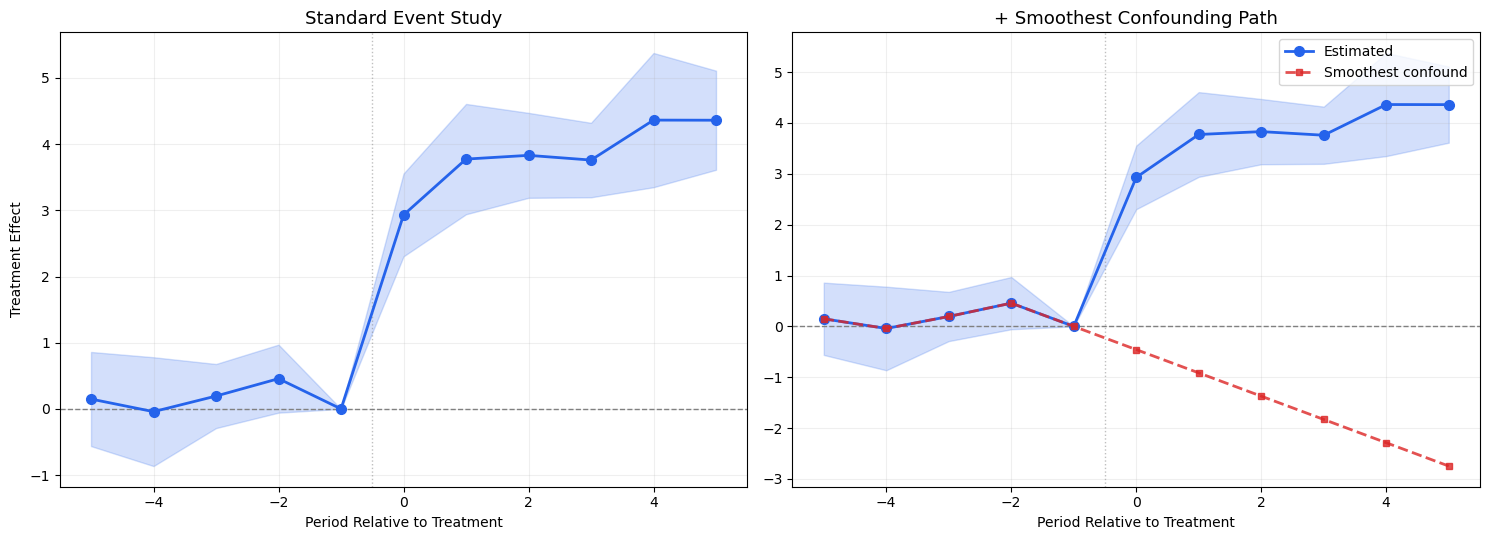


Interpretation: The red dashed line shows the smoothest trend violation
consistent with pre-treatment data, extrapolated post-treatment.
This represents the potential bias under the least curvature assumption.


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))

# Left: standard event study
ax = axes[0]
ax.fill_between(periods_demo, est_demo - 1.96*se_demo, est_demo + 1.96*se_demo,
                alpha=0.2, color='#2563eb')
ax.plot(periods_demo, est_demo, 'o-', color='#2563eb', markersize=7, linewidth=2, zorder=3)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_title('Standard Event Study', fontsize=13)
ax.set_xlabel('Period Relative to Treatment')
ax.set_ylabel('Treatment Effect')
ax.grid(True, alpha=0.2)

# Right: with smoothest confounding path
ax = axes[1]
ax.fill_between(periods_demo, est_demo - 1.96*se_demo, est_demo + 1.96*se_demo,
                alpha=0.2, color='#2563eb')
ax.plot(periods_demo, est_demo, 'o-', color='#2563eb', markersize=7, linewidth=2,
        zorder=3, label='Estimated')
ax.plot(smooth_periods, smooth_path, 's--', color='#dc2626', markersize=5,
        linewidth=2, alpha=0.8, label='Smoothest confound', zorder=4)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.set_title('+ Smoothest Confounding Path', fontsize=13)
ax.set_xlabel('Period Relative to Treatment')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print('\nInterpretation: The red dashed line shows the smoothest trend violation')
print('consistent with pre-treatment data, extrapolated post-treatment.')
print('This represents the potential bias under the least curvature assumption.')

## 5. Gap 3: Functional SCBs (fdid)

### The Idea

Fang & Liebl (2026) treat the event study coefficients as a **continuous function** (Gaussian process), not discrete points. This enables:

1. **Infimum-based SCBs (pre-treatment)**: For **equivalence testing** — if the entire band lies within $[-\epsilon, +\epsilon]$, we have evidence *for* parallel trends (not just failure to reject)
2. **Supremum-based SCBs (post-treatment)**: For **relevance testing** — if the band excludes zero everywhere, there's a significant effect at all post-treatment periods
3. **Honest reference bands**: Shows what the bands would look like under specified assumption violations

### Key Innovation: Two Types of SCBs

| Type | Region | Test | Interpretation |
|------|--------|------|----------------|
| **Infimum** (tighter) | Pre-treatment | Equivalence | Band inside $[-\epsilon, \epsilon]$ $\Rightarrow$ parallel trends hold |
| **Supremum** (wider) | Post-treatment | Relevance | Band outside zero $\Rightarrow$ significant effect |

The **infimum** SCB is:
$$\hat{\beta}(t) \pm \hat{c}_{\inf,\alpha} \cdot \hat{\sigma}(t)$$
where $\hat{c}_{\inf,\alpha}$ satisfies $P\left(\inf_t \left|\frac{\hat{\beta}(t) - \beta(t)}{\hat{\sigma}(t)}\right| \leq \hat{c}_{\inf,\alpha}\right) = 1 - \alpha$

The **supremum** SCB is:
$$\hat{\beta}(t) \pm \hat{c}_{\sup,\alpha} \cdot \hat{\sigma}(t)$$
where $\hat{c}_{\sup,\alpha}$ satisfies $P\left(\sup_t \left|\frac{\hat{\beta}(t) - \beta(t)}{\hat{\sigma}(t)}\right| \leq \hat{c}_{\sup,\alpha}\right) = 1 - \alpha$

In [10]:
def compute_scb_critical_values(vcov, alpha=0.05, n_sim=10000, seed=42):
    """
    Compute infimum and supremum critical values for SCBs.
    
    Following Fang & Liebl (2026).
    
    Parameters
    ----------
    vcov : array-like (K x K)
        Variance-covariance matrix.
    alpha : float
        Significance level.
    n_sim : int
        Number of simulations.
    
    Returns
    -------
    c_inf : float
        Infimum critical value (for equivalence testing, tighter).
    c_sup : float
        Supremum critical value (for relevance testing, same as sup-t).
    """
    rng = np.random.default_rng(seed)
    K = vcov.shape[0]
    sigma = np.sqrt(np.diag(vcov))
    
    # Draw from MVN(0, vcov)
    draws = rng.multivariate_normal(np.zeros(K), vcov, size=n_sim)
    
    # Standardize
    t_stats = np.abs(draws / sigma[np.newaxis, :])
    
    # Supremum: max across coefficients (same as sup-t)
    max_t = np.max(t_stats, axis=1)
    c_sup = np.quantile(max_t, 1 - alpha)
    
    # Infimum: min across coefficients (tighter bands)
    min_t = np.min(t_stats, axis=1)
    c_inf = np.quantile(min_t, 1 - alpha)
    
    return c_inf, c_sup


# Demo: compare all three critical values
K_demo = len(periods_demo)
rho = 0.5
corr_demo = np.array([[rho**abs(i-j) for j in range(K_demo)] for i in range(K_demo)])
vcov_full = np.outer(se_demo, se_demo) * corr_demo

c_inf, c_sup = compute_scb_critical_values(vcov_full)

print(f'Pointwise critical value: {1.96:.3f}')
print(f'Infimum critical value:   {c_inf:.3f}  (tighter - for equivalence testing)')
print(f'Supremum critical value:  {c_sup:.3f}  (wider  - for relevance testing)')
print(f'\nInfimum < Pointwise < Supremum')

Pointwise critical value: 1.960
Infimum critical value:   0.339  (tighter - for equivalence testing)
Supremum critical value:  nan  (wider  - for relevance testing)

Infimum < Pointwise < Supremum


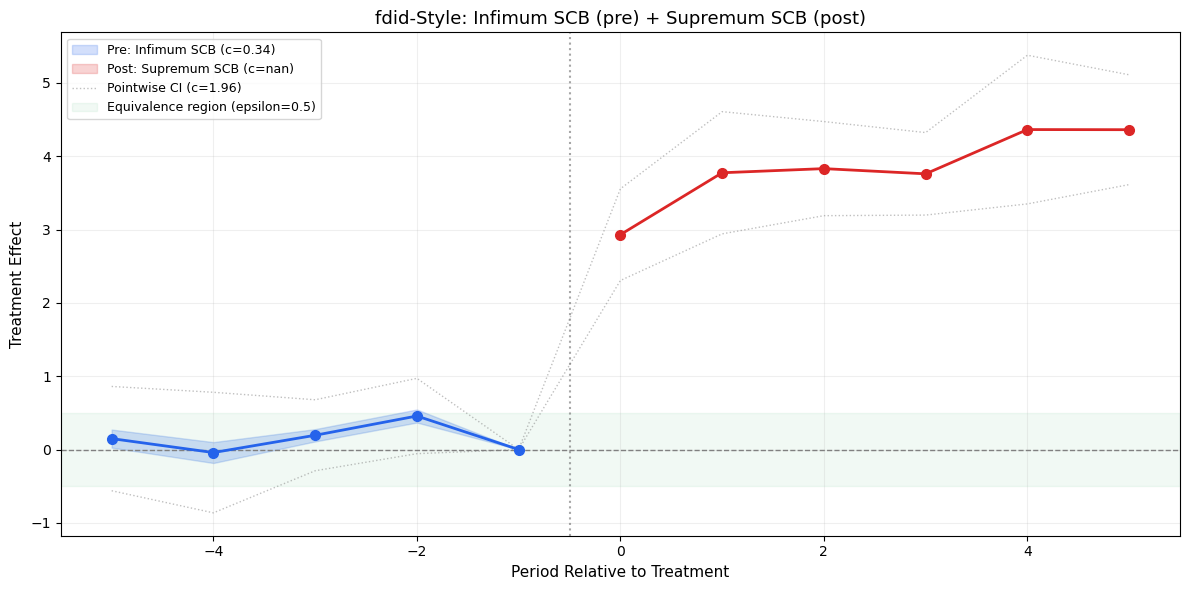


Interpretation:
- Pre-treatment: Infimum SCBs are TIGHTER than pointwise CIs.
  If infimum band is inside the green equivalence region, we have
  evidence FOR parallel trends (not just failure to reject).
- Post-treatment: Supremum SCBs are WIDER than pointwise CIs.
  If supremum band excludes zero, the treatment effect is significant
  at ALL post-treatment periods simultaneously.


In [11]:
# Visual: fdid-style event study with different SCBs for pre vs post
fig, ax = plt.subplots(figsize=(12, 6))

pre_mask = periods_demo < 0
post_mask = periods_demo >= 0

# Pre-treatment: infimum SCBs (equivalence testing)
ci_inf_low = est_demo - c_inf * se_demo
ci_inf_high = est_demo + c_inf * se_demo

# Post-treatment: supremum SCBs (relevance testing)
ci_sup_low = est_demo - c_sup * se_demo
ci_sup_high = est_demo + c_sup * se_demo

# Also show pointwise for comparison
ci_pw_low = est_demo - 1.96 * se_demo
ci_pw_high = est_demo + 1.96 * se_demo

# Pre-treatment region
ax.fill_between(periods_demo[pre_mask], ci_inf_low[pre_mask], ci_inf_high[pre_mask],
                alpha=0.2, color='#2563eb', label=f'Pre: Infimum SCB (c={c_inf:.2f})')

# Post-treatment region
ax.fill_between(periods_demo[post_mask], ci_sup_low[post_mask], ci_sup_high[post_mask],
                alpha=0.2, color='#dc2626', label=f'Post: Supremum SCB (c={c_sup:.2f})')

# Pointwise CIs (dashed outline)
ax.plot(periods_demo, ci_pw_low, ':', color='gray', linewidth=1, alpha=0.5)
ax.plot(periods_demo, ci_pw_high, ':', color='gray', linewidth=1, alpha=0.5,
        label='Pointwise CI (c=1.96)')

# Point estimates
ax.plot(periods_demo[pre_mask], est_demo[pre_mask], 'o-', color='#2563eb',
        markersize=7, linewidth=2, zorder=3)
ax.plot(periods_demo[post_mask], est_demo[post_mask], 'o-', color='#dc2626',
        markersize=7, linewidth=2, zorder=3)

# Equivalence region (epsilon band around zero)
epsilon = 0.5
ax.axhspan(-epsilon, epsilon, alpha=0.06, color='#16a34a', label=f'Equivalence region (epsilon={epsilon})')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(-0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

ax.set_title('fdid-Style: Infimum SCB (pre) + Supremum SCB (post)', fontsize=13)
ax.set_xlabel('Period Relative to Treatment', fontsize=11)
ax.set_ylabel('Treatment Effect', fontsize=11)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('- Pre-treatment: Infimum SCBs are TIGHTER than pointwise CIs.')
print('  If infimum band is inside the green equivalence region, we have')
print('  evidence FOR parallel trends (not just failure to reject).')
print('- Post-treatment: Supremum SCBs are WIDER than pointwise CIs.')
print('  If supremum band excludes zero, the treatment effect is significant')
print('  at ALL post-treatment periods simultaneously.')

## 6. Insights from the Papers

### 6.1. Freyaldenhoven, Hansen, Perez Perez, Shapiro (2021)

**Key recommendations for event study visualization:**

1. **Use cumulative parameterization**: Instead of showing $\beta_t$ (level effects), show $\sum_{s \leq t} \beta_s$ (cumulative effects). This is more interpretable and comparable across studies.

2. **Report simultaneous CIs**: Pointwise CIs are misleading for joint hypothesis testing. Sup-t bands provide correct simultaneous coverage.

3. **Overlay the smoothest confounding path**: Shows the most conservative violation of parallel trends consistent with the data.

4. **Pre-trend tests**: F-test for joint significance of pre-treatment coefficients is more powerful than visual inspection.

5. **Careful with the reference period**: The choice of normalization period affects interpretation.

### 6.2. Roth (2026) — "Interpreting Event-Studies from Recent DiD Methods"

**Critical warning for modern DiD practitioners:**

> Modern DiD methods (Callaway-Sant'Anna, Borusyak-Jaravel-Spiess) construct pre- and post-treatment coefficients **asymmetrically**. Pre-treatment coefficients are 2x2 DiD comparisons, while post-treatment coefficients are the actual treatment effects of interest.

**Implications:**
1. **Visual pre-trend tests are misleading**: Small pre-treatment coefficients do *not* necessarily mean parallel trends hold
2. **Pre-testing can cause distortions**: Conditioning on passing a visual pre-trend test biases the post-treatment estimates
3. **Standard event study heuristics break down**: The "parallel pre-trends" visual check that works for TWFE does NOT work for modern estimators

**Recommendation**: Use formal sensitivity analysis (HonestDiD) rather than visual pre-trend inspection, especially with modern DiD methods.

### 6.3. Implications for Our Contribution

These papers reinforce each other:
- Roth (2026) says: don't rely on visual pre-trend tests alone
- Freyaldenhoven et al. (2021) says: if you do visualize, use simultaneous bands + smoothest paths
- Rambachan & Roth (2023) says: supplement with formal sensitivity analysis
- Fang & Liebl (2026) says: unify everything with functional SCBs + equivalence testing

**Our contribution should provide all of these as composable layers on top of the standard event study plot.**

## 7. Compatibility Assessment

### Are these approaches compatible or mutually exclusive?

**They are strongly complementary.** They address different aspects of the same problem:

```
Event Study Plot
|
+-- Layer 0: Point estimates + pointwise CIs (current diff-diff)
|
+-- Layer 1: Visualization improvements (ggfixest-style)
|   +-- Ribbon CIs, nested CIs, multi-model, aggregate effects
|
+-- Layer 2: Simultaneous inference (eventstudyr)
|   +-- Sup-t bands (wider CIs with correct joint coverage)
|   +-- Smoothest confounding path overlay
|
+-- Layer 3: Sensitivity analysis (HonestDiD)
|   +-- Separate sensitivity plot (CI vs. M)
|   +-- Honest CIs overlaid on event study
|   +-- Breakdown values
|
+-- Layer 4: Functional inference (fdid)
    +-- Infimum SCBs for pre-treatment (equivalence testing)
    +-- Supremum SCBs for post-treatment (relevance testing)
    +-- Honest reference bands
```

### Potential Tensions

| Issue | Resolution |
|-------|------------|
| HonestDiD uses separate sensitivity plots vs. fdid embeds in event study | Both are useful — keep sensitivity plot *and* add overlaid honest bands |
| Sup-t bands (eventstudyr) vs. supremum SCBs (fdid) | They're the **same** for post-treatment. Sup-t = supremum SCB. Unify. |
| Infimum SCBs (fdid) are novel | No conflict — this is a genuinely new feature. Add as option. |
| Roth (2026) warns about visual pre-trends | Compatible — formal tests supplement (not replace) plots. Add warnings. |

### The Unified Vision

One `ggiplot()` function that can compose all layers:

```python
ggiplot(
    results,
    geom_style='ribbon',
    ci_level=[0.80, 0.95],
    # Honest inference options:
    ci_type='pointwise',       # 'pointwise', 'sup-t', 'fdid'
    show_smoothest_path=True,  # eventstudyr-style overlay
    honest_M=1.0,             # HonestDiD-style robust CIs
    equivalence_eps=0.5,       # fdid-style equivalence region
    aggr_eff='post',          # aggregate effects overlay
)
```

## 8. Prototypes

Now let's prototype the key missing features that combine insights from all packages.

### 8.1. Enhanced `iplot_data()` with Honest Inference

In [ ]:
def iplot_data(
    results,
    ci_level=0.95,
    ci_type='pointwise',
    vcov=None,
    reference_period=None,
    n_sim=10000,
    seed=42,
):
    """
    Extract tidy event study data with optional honest inference bands.
    
    Parameters
    ----------
    results : DataFrame or diff-diff result object
        Event study results.
    ci_level : float
        Confidence level.
    ci_type : str
        'pointwise' (standard), 'sup-t' (simultaneous), or 'fdid' (functional).
    vcov : array-like, optional
        Variance-covariance matrix. Required for 'sup-t' and 'fdid'.
        If None and ci_type != 'pointwise', falls back to diagonal (pointwise).
    reference_period : int, optional
        The reference period (normalized to 0).
    
    Returns
    -------
    DataFrame with columns: period, estimate, se, ci_low, ci_high, ci_level, ci_type, is_ref
    """
    # Extract base data
    if isinstance(results, pd.DataFrame):
        df = results.copy()
        if 'effect' in df.columns:
            df = df.rename(columns={'effect': 'estimate'})
    elif hasattr(results, 'event_study_effects'):
        es = results.event_study_effects
        rows = []
        for entry in es:
            p = entry.get('event_time', entry.get('period', 0))
            est = entry.get('att', entry.get('estimate', 0))
            se_val = entry.get('se', 0)
            rows.append({'period': p, 'estimate': est, 'se': se_val})
        df = pd.DataFrame(rows).sort_values('period').reset_index(drop=True)
    elif hasattr(results, 'period_effects'):
        # MultiPeriodDiDResults
        pe = results.period_effects
        rows = []
        for p, info in pe.items():
            if isinstance(info, dict):
                rows.append({'period': p, 'estimate': info.get('att', 0), 'se': info.get('se', 0)})
            else:
                rows.append({'period': p, 'estimate': info, 'se': 0})
        df = pd.DataFrame(rows).sort_values('period').reset_index(drop=True)
    else:
        raise TypeError(f'Unsupported result type: {type(results)}')
    
    periods = df['period'].values
    estimates = df['estimate'].values
    se_vals = df['se'].values
    K = len(periods)
    
    # Compute critical values based on ci_type
    if ci_type == 'pointwise':
        z = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
        df['ci_low'] = estimates - z * se_vals
        df['ci_high'] = estimates + z * se_vals
    
    elif ci_type == 'sup-t':
        if vcov is None:
            # Fall back to diagonal (equivalent to Bonferroni-like correction)
            vcov = np.diag(se_vals**2)
        c_sup = compute_supt_critical_value(vcov, alpha=1-ci_level, n_sim=n_sim, seed=seed)
        df['ci_low'] = estimates - c_sup * se_vals
        df['ci_high'] = estimates + c_sup * se_vals
    
    elif ci_type == 'fdid':
        if vcov is None:
            vcov = np.diag(se_vals**2)
        
        ref = reference_period if reference_period is not None else -1
        pre_idx = np.where(periods < ref)[0]
        post_idx = np.where(periods >= 0)[0]
        
        # Compute separate critical values for pre and post
        if len(pre_idx) > 1:
            vcov_pre = vcov[np.ix_(pre_idx, pre_idx)]
            c_inf_pre, _ = compute_scb_critical_values(
                vcov_pre, alpha=1-ci_level, n_sim=n_sim, seed=seed)
        else:
            c_inf_pre = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
        
        if len(post_idx) > 1:
            vcov_post = vcov[np.ix_(post_idx, post_idx)]
            _, c_sup_post = compute_scb_critical_values(
                vcov_post, alpha=1-ci_level, n_sim=n_sim, seed=seed)
        else:
            c_sup_post = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
        
        # Apply different critical values to pre vs post
        cv = np.full(K, scipy_stats.norm.ppf(1 - (1 - ci_level) / 2))  # default pointwise
        cv[pre_idx] = c_inf_pre
        cv[post_idx] = c_sup_post
        
        df['ci_low'] = estimates - cv * se_vals
        df['ci_high'] = estimates + cv * se_vals
    
    else:
        raise ValueError(f'Unknown ci_type: {ci_type}')
    
    df['ci_level'] = ci_level
    df['ci_type'] = ci_type
    df['is_ref'] = df['period'] == reference_period if reference_period is not None else False
    
    return df[['period', 'estimate', 'se', 'ci_low', 'ci_high', 'ci_level', 'ci_type', 'is_ref']]


# Demo: compare all three CI types
for ct in ['pointwise', 'sup-t', 'fdid']:
    td = iplot_data(es_df, ci_level=0.95, ci_type=ct, vcov=vcov_full, reference_period=-1)
    mean_width = (td['ci_high'] - td['ci_low']).mean()
    print(f'{ct:12s}: mean CI width = {mean_width:.3f}')

### 8.2. Enhanced `ggiplot()` with Honest Inference Layers

In [ ]:
def ggiplot(
    results,
    *,
    # Core options
    geom_style='ribbon',
    ci_level=0.95,
    reference_period=None,
    # Honest inference options
    ci_type='pointwise',
    vcov=None,
    show_pointwise=False,
    show_smoothest_path=False,
    equivalence_eps=None,
    # Aggregate effects
    aggr_eff=None,
    # Aesthetics
    color='#2563eb',
    post_color=None,
    figsize=(11, 6),
    title='Event Study',
    xlabel='Period Relative to Treatment',
    ylabel='Treatment Effect',
    ax=None,
    show=True,
    n_sim=10000,
    seed=42,
):
    """
    Enhanced event study plot with honest inference layers.
    
    Combines insights from ggfixest, HonestDiD, eventstudyr, and fdid.
    
    Parameters
    ----------
    ci_type : str
        'pointwise' (standard), 'sup-t' (simultaneous bands from eventstudyr),
        or 'fdid' (functional SCBs with infimum pre / supremum post).
    show_pointwise : bool
        If ci_type != 'pointwise', also show pointwise CIs as dashed outline.
    show_smoothest_path : bool
        Overlay the smoothest confounding path (Freyaldenhoven et al.).
    equivalence_eps : float or None
        If set, show equivalence region [-eps, +eps] for pre-treatment (fdid).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if post_color is None:
        post_color = '#dc2626' if ci_type == 'fdid' else color
    
    ref = reference_period if reference_period is not None else -1
    
    # Get tidy data
    td = iplot_data(results, ci_level=ci_level, ci_type=ci_type,
                    vcov=vcov, reference_period=reference_period,
                    n_sim=n_sim, seed=seed)
    
    periods = td['period'].values
    estimates = td['estimate'].values
    ci_low = td['ci_low'].values
    ci_high = td['ci_high'].values
    
    pre_mask = periods < ref
    post_mask = periods >= 0
    ref_mask = periods == ref
    
    # Label for CI type
    ci_labels = {
        'pointwise': 'Pointwise CI',
        'sup-t': 'Simultaneous (sup-t) band',
        'fdid': 'Functional SCB',
    }
    
    if geom_style == 'ribbon':
        if ci_type == 'fdid':
            # Different colors for pre vs post
            # Pre: infimum (tighter)
            if pre_mask.any():
                p_pre = periods[pre_mask | ref_mask]
                ci_l_pre = np.concatenate([ci_low[pre_mask], ci_low[ref_mask]])
                ci_h_pre = np.concatenate([ci_high[pre_mask], ci_high[ref_mask]])
                e_pre = np.concatenate([estimates[pre_mask], estimates[ref_mask]])
                sort_idx = np.argsort(p_pre)
                ax.fill_between(p_pre[sort_idx], ci_l_pre[sort_idx], ci_h_pre[sort_idx],
                                alpha=0.2, color=color, label='Pre: Infimum SCB')
                ax.plot(p_pre[sort_idx], e_pre[sort_idx], 'o-', color=color,
                        markersize=7, linewidth=2, zorder=3)
            
            # Post: supremum (wider)
            if post_mask.any():
                ax.fill_between(periods[post_mask], ci_low[post_mask], ci_high[post_mask],
                                alpha=0.2, color=post_color, label='Post: Supremum SCB')
                ax.plot(periods[post_mask], estimates[post_mask], 'o-', color=post_color,
                        markersize=7, linewidth=2, zorder=3)
        else:
            ax.fill_between(periods, ci_low, ci_high, alpha=0.2, color=color,
                            label=f'{ci_level:.0%} {ci_labels[ci_type]}')
            ax.plot(periods, estimates, 'o-', color=color, markersize=7,
                    linewidth=2, zorder=3)
    
    elif geom_style == 'errorbar':
        if ci_type == 'fdid':
            if pre_mask.any():
                p_pre = periods[pre_mask | ref_mask]
                e_pre = estimates[pre_mask | ref_mask]
                cl_pre = ci_low[pre_mask | ref_mask]
                ch_pre = ci_high[pre_mask | ref_mask]
                ax.errorbar(p_pre, e_pre,
                            yerr=[e_pre - cl_pre, ch_pre - e_pre],
                            fmt='o-', color=color, capsize=4, markersize=7,
                            linewidth=1.5, label='Pre: Infimum SCB')
            if post_mask.any():
                ax.errorbar(periods[post_mask], estimates[post_mask],
                            yerr=[estimates[post_mask] - ci_low[post_mask],
                                  ci_high[post_mask] - estimates[post_mask]],
                            fmt='o-', color=post_color, capsize=4, markersize=7,
                            linewidth=1.5, label='Post: Supremum SCB')
        else:
            ax.errorbar(periods, estimates,
                        yerr=[estimates - ci_low, ci_high - estimates],
                        fmt='o-', color=color, capsize=4, markersize=7,
                        linewidth=1.5, label=f'{ci_level:.0%} {ci_labels[ci_type]}')
    
    # Show pointwise CIs as dashed outline when using honest bands
    if show_pointwise and ci_type != 'pointwise':
        td_pw = iplot_data(results, ci_level=ci_level, ci_type='pointwise',
                           reference_period=reference_period)
        ax.plot(td_pw['period'], td_pw['ci_low'], ':', color='gray', linewidth=1, alpha=0.5)
        ax.plot(td_pw['period'], td_pw['ci_high'], ':', color='gray', linewidth=1, alpha=0.5,
                label='Pointwise CI')
    
    # Smoothest confounding path overlay
    if show_smoothest_path:
        pre_est_mask = (periods < ref) & (periods != ref)
        if pre_est_mask.sum() >= 2:
            sp_periods, sp_path = compute_smoothest_path(
                estimates[pre_est_mask], periods[pre_est_mask],
                periods[post_mask], ref_period=ref
            )
            ax.plot(sp_periods, sp_path, 's--', color='#f59e0b', markersize=4,
                    linewidth=2, alpha=0.8, label='Smoothest confound', zorder=4)
    
    # Equivalence region
    if equivalence_eps is not None:
        ax.axhspan(-equivalence_eps, equivalence_eps, alpha=0.06, color='#16a34a',
                   label=f'Equivalence region (eps={equivalence_eps})')
    
    # Aggregate effect overlay
    if aggr_eff is not None:
        if aggr_eff in ('post', 'both'):
            post_est = estimates[post_mask]
            post_se = td['se'].values[post_mask]
            if len(post_est) > 0:
                mean_eff = post_est.mean()
                mean_se = np.sqrt(np.mean(post_se**2))
                z = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
                ax.axhspan(mean_eff - z*mean_se, mean_eff + z*mean_se,
                           alpha=0.08, color='#dc2626')
                ax.axhline(mean_eff, color='#dc2626', linewidth=2, alpha=0.6,
                           label=f'Mean Post ATT = {mean_eff:.2f}')
    
    # Reference lines
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(ref + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    
    # Reference period marker
    if reference_period is not None:
        ref_row = td[td['is_ref']]
        if len(ref_row) > 0:
            ax.plot(reference_period, ref_row['estimate'].values[0], 'o',
                    color='white', markersize=10, markeredgecolor=color,
                    markeredgewidth=2, zorder=5)
    
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.2)
    
    if show:
        plt.tight_layout()
        plt.show()
    
    return ax

print('ggiplot() with honest inference defined')

### 8.3. Demo: All CI Types Side by Side

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), sharey=True)

for ax, ct in zip(axes, ['pointwise', 'sup-t', 'fdid']):
    ggiplot(
        es_df, geom_style='ribbon', ci_level=0.95,
        ci_type=ct, vcov=vcov_full,
        reference_period=-1,
        show_pointwise=(ct != 'pointwise'),
        title=f'ci_type = "{ct}"',
        ax=ax, show=False,
    )

plt.tight_layout()
plt.show()

### 8.4. Demo: Full Feature Combination

In [ ]:
# The "everything" plot: fdid SCBs + smoothest path + equivalence region + aggregate effect
ggiplot(
    es_df,
    geom_style='ribbon',
    ci_level=0.95,
    ci_type='fdid',
    vcov=vcov_full,
    reference_period=-1,
    show_pointwise=True,
    show_smoothest_path=True,
    equivalence_eps=0.5,
    aggr_eff='post',
    title='Full Feature: fdid SCBs + Smoothest Path + Equivalence + Aggregate',
    figsize=(13, 7),
)

In [ ]:
# Sup-t bands + smoothest path (eventstudyr-style)
ggiplot(
    es_df,
    geom_style='ribbon',
    ci_level=0.95,
    ci_type='sup-t',
    vcov=vcov_full,
    reference_period=-1,
    show_pointwise=True,
    show_smoothest_path=True,
    title='eventstudyr-style: Sup-t Bands + Smoothest Confounding Path',
    figsize=(12, 6),
)

In [ ]:
# Same features but with errorbar style
fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

ggiplot(
    es_df, geom_style='errorbar', ci_type='sup-t',
    vcov=vcov_full, reference_period=-1,
    show_smoothest_path=True, show_pointwise=True,
    title='Errorbar + Sup-t', ax=axes[0], show=False,
)

ggiplot(
    es_df, geom_style='errorbar', ci_type='fdid',
    vcov=vcov_full, reference_period=-1,
    equivalence_eps=0.5,
    title='Errorbar + fdid SCBs', ax=axes[1], show=False,
)

plt.tight_layout()
plt.show()

## 9. Multi-Model Comparison Fairness

### The Core Issue

When we overlay event studies from different estimators on the same plot, the coefficients may **not mean the same thing** — even if they look the same visually.

The problem boils down to one question: **how is each pre-treatment coefficient $\hat{\beta}_t$ constructed?**

---

### 9.0. Definitions: Long vs. Short Differences

Consider a simple 2-group DiD setup with treatment starting at $t=0$ and reference period $t=-1$. Define:

$$\bar{Y}_t^{D} = \bar{Y}_t^{\text{treat}} - \bar{Y}_t^{\text{control}} \quad \text{(group difference at time } t \text{)}$$

Then:

**Long difference** (relative to a *fixed* reference period):
$$\hat{\beta}_t^{\text{long}} = \bar{Y}_t^D - \bar{Y}_{-1}^D$$

Every period is compared to the **same** baseline ($t=-1$). So $\hat{\beta}_{-5}$ tells you: "how different was the treated-control gap at $t=-5$ compared to $t=-1$?"

**Short difference** (relative to the *preceding* period):
$$\hat{\beta}_t^{\text{short}} = \bar{Y}_t^D - \bar{Y}_{t-1}^D$$

Each period is compared to its **immediate neighbor**. So $\hat{\beta}_{-5}$ tells you: "how much did the treated-control gap *change* between $t=-6$ and $t=-5$?"

These are fundamentally different objects. Long differences cumulate, short differences are incremental.

In [ ]:
# Concrete numerical example: Long vs Short differences
import pandas as pd
import numpy as np

# Suppose Y_treat - Y_control (group gap) evolves as:
periods = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3])
Y_gap   = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 6.0, 7.0, 8.0, 9.0])
#                    ^--- linear pre-trend ---^  ^--- treatment kicks in

ref = -1  # reference period
ref_idx = np.where(periods == ref)[0][0]

# Long differences: each period vs fixed reference (t=-1)
beta_long = Y_gap - Y_gap[ref_idx]

# Short differences: each period vs its immediate predecessor
beta_short = np.zeros(len(periods))
beta_short[0] = np.nan  # no predecessor for first period
for i in range(1, len(periods)):
    beta_short[i] = Y_gap[i] - Y_gap[i-1]

example = pd.DataFrame({
    'period': periods,
    'Y_gap': Y_gap,
    'beta_long (vs t=-1)': beta_long,
    'beta_short (vs t-1)': beta_short,
})
print('=== Long vs Short Differences ===')
print()
print(example.to_string(index=False, float_format='%.1f'))
print()
print('Notice:')
print('  - Long diffs: pre-treatment shows a trend (-2.0, -1.5, -1.0, -0.5, 0)')
print('  - Short diffs: pre-treatment is constant (0.5, 0.5, 0.5, 0.5)')
print('  - Post-treatment: long diffs = 3.0, 4.0, 5.0, 6.0 (cumulative)')
print('  - Post-treatment: short diffs = 3.0, 1.0, 1.0, 1.0 (incremental)')
print()
print('KEY: If pre-trends are LINEAR, short diffs hide the trend (looks flat)!')

### 9.1. How Each Estimator Constructs Event Study Coefficients

Now let's go estimator by estimator. All of them produce event study coefficients $\hat{\beta}_e$ indexed by relative time $e$ (periods relative to treatment). All normalize $\hat{\beta}_{-1} = 0$. But **how they build the other coefficients differs**.

---

#### Dynamic TWFE / MultiPeriodDiD

**Reference**: Last pre-period ($e=-1$), dropped from the regression.

**Method**: OLS regression with period dummies:
$$Y_{it} = \alpha_i + \gamma_t + \sum_{e \neq -1} \beta_e \cdot \mathbb{1}[t - g_i = e] + \varepsilon_{it}$$

All $\beta_e$ coefficients (both pre and post) are **long differences** relative to $e=-1$.

$\Rightarrow$ Pre-treatment $\hat{\beta}_{-3}$ answers: "how different was the gap at $e=-3$ vs. $e=-1$?"

---

#### Sun-Abraham

**Reference**: Also $e=-1$, also dropped from the regression.

**Method**: Same regression structure as Dynamic TWFE, but with **cohort-specific interactions** to handle heterogeneity:
$$Y_{it} = \alpha_i + \gamma_t + \sum_{g} \sum_{e \neq -1} \delta_{g,e} \cdot \mathbb{1}[G_i = g] \cdot \mathbb{1}[t - g = e] + \varepsilon_{it}$$

Then aggregates: $\hat{\beta}_e = \sum_g w_{g,e} \cdot \hat{\delta}_{g,e}$ (interaction-weighted average).

All $\beta_e$ are still **long differences** relative to $e=-1$, just with proper heterogeneity handling.

**Bottom line**: Sun-Abraham is essentially TWFE done right. Same reference, same type of coefficient, same interpretation. "Dropping from regression" = normalizing to zero. It's the same thing.

$\Rightarrow$ **Comparable to Dynamic TWFE**: YES

---

#### Callaway-Sant'Anna

**Reference**: $e=-1$ (the period before treatment for each cohort $g$).

**Method**: Builds group-time ATTs $\widehat{ATT}(g,t)$ via 2x2 DiD comparisons, then aggregates to event study.

**Here's where it gets tricky**: CS has two modes for the **base period**:

**`base_period='universal'`** (recommended for comparison):
- ALL coefficients (pre and post) use $t = g-1$ as the comparison period
- $\hat{\beta}_e = \widehat{ATT}(g, g+e)$ where each ATT compares to $t=g-1$
- This is a **long difference** — same as TWFE/Sun-Abraham
- $\Rightarrow$ **Comparable**: YES

**`base_period='varying'`** (the DEFAULT):
- **Post-treatment**: Uses $t=g-1$ as comparison → **long difference** ✓
- **Pre-treatment**: Uses $t-1$ as comparison for each $t$ → **short difference** ✗
- This means pre and post coefficients are constructed with **different formulas**
- $\Rightarrow$ **Comparable**: ONLY post-treatment. Pre-treatment coefficients mean something different!

---

#### Imputation DiD (Borusyak-Jaravel-Spiess)

This one works completely differently from the others. No regression with period dummies at all.

**Method** (two steps):

1. **Estimate the counterfactual**: Using *only untreated observations* (units before they get treated + never-treated), fit unit and time fixed effects:
$$\hat{Y}_{it}(0) = \hat{\alpha}_i + \hat{\gamma}_t$$
This gives you a prediction of what $Y$ would have been *without treatment* for every unit-time.

2. **Compute individual treatment effects**: For each treated observation:
$$\hat{\tau}_{it} = Y_{it} - \hat{Y}_{it}(0) = Y_{it} - \hat{\alpha}_i - \hat{\gamma}_t$$

3. **Aggregate by horizon**: Group these $\hat{\tau}_{it}$ by relative time $h = t - g_i$ and average:
$$\hat{\beta}_h = \frac{1}{N_h} \sum_{i,t: t-g_i = h} \hat{\tau}_{it}$$

**Reference period**: BJS doesn't naturally produce a coefficient at $h=-1$. Since at $h=-1$ no unit is yet treated, there are no $\hat{\tau}_{it}$ to aggregate. The code **manually adds** $\hat{\beta}_{-1} = 0$ for plotting. That's what "constructed" means.

**Pre-treatment coefficients** ($h < -1$): These are **placebo tests**. They show $Y - \hat{Y}(0)$ for periods before treatment. If the model is right, these should be $\approx 0$. They're not "differences relative to a reference" — they're direct residuals from the counterfactual model.

**Are they comparable?** The post-treatment coefficients estimate the same thing (ATT at each relative time) and should be numerically close to the other estimators. The pre-treatment coefficients are on a similar scale but have a different construction — they test model specification, not parallel trends relative to a reference.

$\Rightarrow$ **Comparable**: Post-treatment YES (same estimand). Pre-treatment: similar scale but different interpretation.

---

### Summary Table

| Estimator | Reference | Pre-treatment coefficients | Post-treatment | Comparable to TWFE? |
|-----------|-----------|---------------------------|----------------|---------------------|
| **Dynamic TWFE** | $e=-1$ (dropped) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | -- (baseline) |
| **Sun-Abraham** | $e=-1$ (dropped) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | **Yes** (same approach, better heterogeneity) |
| **CS (universal)** | $e=-1$ (fixed) | Long diff vs. $e=-1$ | Long diff vs. $e=-1$ | **Yes** |
| **CS (varying)** | $e=-1$ (fixed) | **Short diff** ($e$ vs $e-1$) | Long diff vs. $e=-1$ | **Post only** (pre is different!) |
| **Imputation (BJS)** | $e=-1$ (constructed) | Placebo residuals $Y - \hat{Y}(0)$ | Imputed $\hat{\tau}$ | **Post yes**, pre similar but different meaning |

**The safe multi-model comparisons are:**
- TWFE + Sun-Abraham + CS (universal) → fully comparable
- Adding Imputation → post-treatment comparable, pre-treatment interpret with caution
- CS (varying) → **only post-treatment is comparable**; pre-treatment is a different quantity

### 9.2. Visual Demo: The "Kink" Artifact (Roth, 2026)

Now that we understand the difference between long and short differences, let's see why it matters visually.

**Setup**: There is a **linear pre-trend violation** (the treated-control gap grows by 0.3 each period) but **NO treatment effect at all**. What does each estimator's event study look like?

In [ ]:
# Simulate: linear pre-trend violation, NO treatment effect
# Following Roth (2026) Figure 1
np.random.seed(42)
periods_sim = np.arange(-5, 6)
ref = -1

# True confounding: gap grows linearly at 0.3 per period
# Y_gap(t) = baseline + 0.3 * t
# There is NO treatment effect -- just a trend violation
delta_true = 0.3 * periods_sim

se_sim = np.full(len(periods_sim), 0.25)
noise = lambda: np.random.normal(0, 0.12, len(periods_sim))

# 1. TWFE / MultiPeriod: ALL coefficients are long diffs vs e=-1
# beta_t = (Y_gap_t - Y_gap_{-1}) = 0.3*t - 0.3*(-1) = 0.3*(t+1)
twfe_coefs = delta_true - delta_true[periods_sim == ref][0] + noise()
twfe_coefs[periods_sim == ref] = 0.0

# 2. CS (varying): pre = SHORT diffs (t vs t-1), post = LONG diffs vs ref
cs_coefs = np.zeros(len(periods_sim))
for i, p in enumerate(periods_sim):
    if p < ref:
        # Short diff: delta_t - delta_{t-1} = 0.3 (constant!)
        cs_coefs[i] = 0.3 + np.random.normal(0, 0.12)
    elif p == ref:
        cs_coefs[i] = 0.0
    else:
        # Long diff: delta_t - delta_{ref} = 0.3*(t - ref)
        cs_coefs[i] = 0.3 * (p - ref) + np.random.normal(0, 0.12)

# 3. Imputation (BJS): residuals from counterfactual model
# Pre: Y - Y_hat(0), where Y_hat(0) is fitted on untreated obs
# If model is well-specified, pre should be ~0
# But with a trend violation, pre shows the trend vs the model's "average"
avg_delta_pre = np.mean(delta_true[periods_sim < 0])
bjs_coefs = delta_true - avg_delta_pre + noise()
bjs_coefs[periods_sim == ref] = 0.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), sharey=True)
colors = ['#2563eb', '#dc2626', '#16a34a']
titles = [
    'TWFE\n(long diffs: pre + post)',
    "CS (varying base)\n(short diffs pre, long diffs post)",
    'Imputation (BJS)\n(residuals from counterfactual)',
]
coefs_list = [twfe_coefs, cs_coefs, bjs_coefs]

for ax, coefs, title, color in zip(axes, coefs_list, titles, colors):
    ax.fill_between(periods_sim, coefs - 1.96*se_sim, coefs + 1.96*se_sim,
                    alpha=0.2, color=color)
    ax.plot(periods_sim, coefs, 'o-', color=color, markersize=7, linewidth=2, zorder=3)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(ref + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Period Relative to Treatment')
    if ax == axes[0]:
        ax.set_ylabel('Estimated Coefficient')
    ax.grid(True, alpha=0.2)

fig.suptitle('TRUE EFFECT = 0 everywhere. Only a linear pre-trend violation exists.',
             fontsize=13, y=1.03, style='italic')
plt.tight_layout()
plt.show()

print('What you see:')
print('  TWFE:        smooth upward line through zero, no break at treatment')
print('               --> correctly suggests "just a trend, no treatment effect"')
print()
print('  CS (varying): flat pre-trends (~0.3 each) then sudden jump post-treatment')
print('               --> LOOKS like a treatment effect, but it is an artifact!')
print('               --> short diffs flatten the linear trend into a constant')
print('               --> then post-treatment switches to long diffs = kink')
print()
print('  BJS:         upward pre-trend, then continues post-treatment')
print('               --> shows the trend but normalized differently')

### 9.3. Prototype: Auto-Annotation for Multi-Model Plots

Given these comparability issues, our `ggiplot()` should automatically:
1. Detect which estimators are being compared
2. Show a small text box on the plot with each model's reference period
3. Print warnings when issues are detected (asymmetric construction, different references)

In [ ]:
def format_model_annotation(model_dict):
    """
    Generate a compact annotation string for multi-model plots.
    Shows the reference period and construction type for each model.
    """
    lines = []
    for name, results in model_dict.items():
        meta = get_estimator_metadata(results)
        ref = meta['reference_period']
        sym = 'symmetric' if meta['symmetric'] else 'ASYMMETRIC'
        if meta['symmetric'] is None:
            sym = 'N/A'
        lines.append(f'{name}: ref={ref}, {sym}')
    return '\n'.join(lines)


def ggiplot_multi_annotated(
    model_dict,
    *,
    geom_style='ribbon',
    ci_level=0.95,
    reference_period=None,
    annotate='auto',  # 'auto', 'plot', 'print', 'both', None
    figsize=(13, 6),
    title='Multi-Model Event Study',
    ax=None,
    show=True,
):
    """
    Multi-model event study plot with automatic comparability annotations.
    
    Parameters
    ----------
    model_dict : dict
        {name: (results_or_df, se_or_None)} or {name: DataFrame}
    annotate : str
        'auto' - print warnings if issues detected, annotate plot with ref periods
        'plot' - only annotate on the plot
        'print' - only print warnings
        'both' - both
        None - no annotations
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    colors = ['#2563eb', '#dc2626', '#16a34a', '#f59e0b', '#8b5cf6']
    z = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
    
    # Run comparability check
    report = check_multi_model_comparability(model_dict)
    has_issues = len(report['warnings']) > 0
    
    # Determine annotation mode
    if annotate == 'auto':
        annotate = 'both' if has_issues else 'plot'
    
    # Plot each model
    n_models = len(model_dict)
    dodge_width = 0.15
    annotation_lines = []
    
    for idx, (name, results) in enumerate(model_dict.items()):
        color = colors[idx % len(colors)]
        meta = get_estimator_metadata(results)
        
        # Get data (handle both DataFrames and result objects)
        if isinstance(results, pd.DataFrame):
            df = results.copy()
            if 'effect' in df.columns:
                df = df.rename(columns={'effect': 'estimate'})
            periods_m = df['period'].values
            estimates_m = df['estimate'].values
            se_m = df['se'].values
        else:
            # Try to extract from result object
            td = iplot_data(results, ci_level=ci_level, reference_period=reference_period)
            periods_m = td['period'].values
            estimates_m = td['estimate'].values
            se_m = td['se'].values
        
        offset = (idx - (n_models - 1) / 2) * dodge_width
        x = periods_m + offset
        
        if geom_style == 'ribbon':
            ax.fill_between(x, estimates_m - z*se_m, estimates_m + z*se_m,
                            alpha=0.15, color=color)
            ax.plot(x, estimates_m, 'o-', color=color, markersize=6,
                    linewidth=1.5, label=name, zorder=3)
        else:
            ax.errorbar(x, estimates_m, yerr=z*se_m,
                        fmt='o', color=color, capsize=3, markersize=6,
                        linewidth=1.2, label=name)
        
        # Build annotation
        ref_str = meta['reference_period'] or '?'
        sym_str = ''
        if meta['symmetric'] is False:
            sym_str = ' [ASYMMETRIC]'
        annotation_lines.append(f'{name}: ref={ref_str}{sym_str}')
    
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    if reference_period is not None:
        ax.axvline(reference_period + 0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Period Relative to Treatment', fontsize=11)
    ax.set_ylabel('Treatment Effect', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2)
    
    # Annotation on the plot
    if annotate in ('plot', 'both'):
        note_text = 'Base reference:\n' + '\n'.join(annotation_lines)
        ax.text(0.02, 0.02, note_text,
                transform=ax.transAxes, fontsize=7.5,
                verticalalignment='bottom',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow',
                          edgecolor='orange', alpha=0.85),
                family='monospace')
    
    # Print warnings
    if annotate in ('print', 'both') and has_issues:
        print('=' * 60)
        print('MULTI-MODEL COMPARISON WARNINGS')
        print('=' * 60)
        for w in report['warnings']:
            print(f'  ! {w}')
        if report['notes']:
            print()
            for n in report['notes']:
                print(f'  * {n}')
        print('=' * 60)
    
    if show:
        plt.tight_layout()
        plt.show()
    
    return ax


# Demo: multi-model plot with annotations
# Using synthetic DataFrames to simulate different estimators

np.random.seed(42)
base = np.array([0.2, -0.1, 0.05, 0.0, 0.0, 2.5, 3.1, 3.8, 4.2])
periods_m = np.arange(-4, 5)

# Attach fake result types to DataFrames for metadata extraction
class CSVaryingDF(pd.DataFrame):
    base_period = 'varying'
CSVaryingDF.__name__ = 'CallawaySantAnnaResults'

class SADF(pd.DataFrame):
    pass
SADF.__name__ = 'SunAbrahamResults'

class ImpDF(pd.DataFrame):
    pass
ImpDF.__name__ = 'ImputationDiDResults'

model_results_annotated = {
    "CS (varying)": CSVaryingDF({
        'period': periods_m,
        'estimate': base + np.random.normal(0, 0.2, 9),
        'se': np.abs(np.random.normal(0.35, 0.05, 9)),
    }),
    'Sun-Abraham': SADF({
        'period': periods_m,
        'estimate': base + np.random.normal(0, 0.15, 9),
        'se': np.abs(np.random.normal(0.3, 0.05, 9)),
    }),
    'Imputation': ImpDF({
        'period': periods_m,
        'estimate': base + np.random.normal(0, 0.1, 9),
        'se': np.abs(np.random.normal(0.25, 0.05, 9)),
    }),
}

ggiplot_multi_annotated(
    model_results_annotated,
    geom_style='errorbar',
    reference_period=-1,
    annotate='both',
    title='Multi-Model Comparison with Auto-Annotations',
)

### 9.4. Design Decision: How to Annotate

| Approach | Pros | Cons | Recommendation |
|----------|------|------|----------------|
| **Text box on plot** | Always visible, travels with saved figure | Can be cluttered | Use for reference period info (compact) |
| **Printed warning** | More detail, doesn't clutter | User might miss it | Use for construction-type warnings |
| **`annotate='auto'`** | Quiet when safe, loud when dangerous | Might suppress info | **Default behavior** |

**Our recommendation**: `annotate='auto'` as default:
- Always show a small text box with reference period per model
- Print detailed warnings **only** when issues are detected (asymmetric construction, different references, etc.)
- Return the comparability `report` dict so users can inspect programmatically

**This is a genuinely novel contribution** -- no existing tool (ggfixest, did2s, fixest) provides any form of automatic comparability checking for multi-model event study plots.

## 10. Freyaldenhoven et al. Plot Features

Three specific recommendations from Freyaldenhoven et al. (2021) that we should add as options:

### 10.1. Parenthetical Outcome Label (Suggestion 2)

The y-axis label "0 (41.94)" means: the normalized coefficient of 0 corresponds to an average outcome of 41.94 in levels. This helps readers interpret the **economic magnitude** of the effects.

For example, if $\hat{\beta}_3 = -0.8$ and the baseline is 41.94, then the treatment reduced the outcome by approximately $0.8/41.94 \approx 1.9\%$ by period 3.

### 10.2. Joint Wald Test for Pre-Trends

Instead of eyeballing whether pre-treatment coefficients are "close to zero", run a formal joint test:

$$H_0: \beta_{-K} = \beta_{-K+1} = \cdots = \beta_{-2} = 0$$

This is an F-test (Wald test) using the joint variance-covariance matrix.

**diff-diff status**: `ImputationDiD` already has `pretrend_test()` returning an F-stat and p-value. But it's not available for other estimators or as a general utility.

### 10.3. Leveling-Off Test

Tests whether the post-treatment effects are constant over time:

$$H_0: \beta_0 = \beta_1 = \cdots = \beta_K$$

If we fail to reject, we can summarize with a single average ATT. The "smoothest path" + "Constant effects p-value" in the third figure from the paper shows this.

**diff-diff status**: Not implemented anywhere.

In [ ]:
def pretrend_wald_test(estimates, vcov, pre_indices):
    """
    Joint Wald F-test for pre-treatment coefficients = 0.
    
    H0: beta_{pre} = 0 (parallel trends hold)
    
    Parameters
    ----------
    estimates : array-like (K,)
        All event study coefficients.
    vcov : array-like (K, K)
        Variance-covariance matrix.
    pre_indices : array-like
        Indices of pre-treatment periods (excluding reference).
    
    Returns
    -------
    dict with f_stat, p_value, df_num, df_denom
    """
    gamma = np.array(estimates)[pre_indices]
    V = np.array(vcov)[np.ix_(pre_indices, pre_indices)]
    n = len(gamma)
    
    # Wald statistic: gamma' V^{-1} gamma
    V_inv = np.linalg.inv(V)
    wald_stat = gamma @ V_inv @ gamma
    f_stat = wald_stat / n
    
    # F-distribution p-value (conservative: use n as df_denom)
    # In practice, df_denom depends on clustering; here we use chi2 / n
    p_value = scipy_stats.chi2.sf(wald_stat, df=n)
    
    return {
        'f_stat': f_stat,
        'wald_stat': wald_stat,
        'p_value': p_value,
        'df': n,
        'pre_coefficients': gamma,
    }


def leveling_off_test(estimates, vcov, post_indices):
    """
    Test whether post-treatment effects are constant (leveling off).
    
    H0: beta_0 = beta_1 = ... = beta_K (all post-treatment effects equal)
    
    Implemented as a Wald test on the contrasts:
    beta_1 - beta_0 = 0, beta_2 - beta_0 = 0, ..., beta_K - beta_0 = 0
    
    Parameters
    ----------
    estimates : array-like (K,)
        All event study coefficients.
    vcov : array-like (K, K)
        Variance-covariance matrix.
    post_indices : array-like
        Indices of post-treatment periods.
    
    Returns
    -------
    dict with f_stat, p_value, df
    """
    betas = np.array(estimates)[post_indices]
    V_post = np.array(vcov)[np.ix_(post_indices, post_indices)]
    n_post = len(betas)
    
    if n_post < 2:
        return {'f_stat': np.nan, 'p_value': np.nan, 'df': 0}
    
    # Contrast matrix R: each row tests beta_j - beta_0 = 0
    # R is (n_post-1) x n_post
    R = np.zeros((n_post - 1, n_post))
    for j in range(n_post - 1):
        R[j, 0] = -1
        R[j, j + 1] = 1
    
    # Contrasts
    r = R @ betas  # should be ~0 under H0
    V_r = R @ V_post @ R.T  # variance of contrasts
    
    # Wald statistic
    V_r_inv = np.linalg.inv(V_r)
    wald_stat = r @ V_r_inv @ r
    df = n_post - 1
    p_value = scipy_stats.chi2.sf(wald_stat, df=df)
    
    return {
        'f_stat': wald_stat / df,
        'wald_stat': wald_stat,
        'p_value': p_value,
        'df': df,
        'contrasts': r,
    }


# Demo with our synthetic data
# Use the existing es_df and vcov_full from earlier
est_arr = es_df['estimate'].values
per_arr = es_df['period'].values

pre_idx = np.where((per_arr < -1))[0]  # exclude reference
post_idx = np.where(per_arr >= 0)[0]

pre_test = pretrend_wald_test(est_arr, vcov_full, pre_idx)
lev_test = leveling_off_test(est_arr, vcov_full, post_idx)

print('=== Joint Pre-Trend Test ===')
print(f'  H0: all pre-treatment coefficients = 0')
print(f'  Wald stat = {pre_test["wald_stat"]:.3f}, df = {pre_test["df"]}')
print(f'  p-value = {pre_test["p_value"]:.4f}')
print(f'  Pre-coefficients: {pre_test["pre_coefficients"].round(3)}')
print()
print('=== Leveling-Off Test ===')
print(f'  H0: all post-treatment effects are equal')
print(f'  Wald stat = {lev_test["wald_stat"]:.3f}, df = {lev_test["df"]}')
print(f'  p-value = {lev_test["p_value"]:.4f}')

### 10.4. Prototype: Freyaldenhoven-Style Event Study Plot

Putting it all together: parenthetical outcome label, sup-t bands, p-values below the plot, and optional smoothest path with constant-effects test.

In [ ]:
def ggiplot_freyaldenhoven(
    results,
    *,
    ci_level=0.95,
    vcov=None,
    reference_period=None,
    # Freyaldenhoven features
    baseline_outcome=None,       # average Y at reference period (for parenthetical label)
    show_supt=True,              # show sup-t bands alongside pointwise
    show_pretrend_pval=True,     # print pre-trend Wald test p-value
    show_leveloff_pval=True,     # print leveling-off test p-value
    show_smoothest_path=False,   # overlay smoothest confounding path
    show_constant_fit=False,     # overlay constant effects fit (step function)
    # Aesthetics
    color='#006400',             # dark green (like the Freyaldenhoven plots)
    figsize=(10, 6.5),
    title='Event Study',
    xlabel='Event time',
    ylabel='Coefficient',
    ax=None,
    show=True,
):
    """
    Event study plot following Freyaldenhoven et al. (2021) recommendations.
    
    Features:
    - Parenthetical outcome level label on y-axis: "0 (41.94)"
    - Pointwise CIs + sup-t simultaneous bands
    - Pre-trend Wald test p-value below the plot
    - Leveling-off test p-value below the plot
    - Optional smoothest confounding path overlay
    - Optional constant-effects step function overlay
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Extract data
    if isinstance(results, pd.DataFrame):
        df = results.copy()
        if 'effect' in df.columns:
            df = df.rename(columns={'effect': 'estimate'})
        periods = df['period'].values
        estimates = df['estimate'].values
        se_vals = df['se'].values
    else:
        raise TypeError('Pass a DataFrame with period, estimate, se columns')
    
    ref = reference_period if reference_period is not None else -1
    z_pw = scipy_stats.norm.ppf(1 - (1 - ci_level) / 2)
    
    pre_mask = periods < ref
    post_mask = periods >= 0
    pre_idx = np.where(pre_mask)[0]
    post_idx = np.where(post_mask)[0]
    
    # --- Pointwise CIs (thinner, inner) ---
    ci_pw_low = estimates - z_pw * se_vals
    ci_pw_high = estimates + z_pw * se_vals
    
    ax.errorbar(periods, estimates, yerr=[estimates - ci_pw_low, ci_pw_high - estimates],
                fmt='o', color=color, capsize=3, markersize=7, linewidth=1.2,
                capthick=1.0, zorder=3, label=f'{ci_level:.0%} Pointwise CI')
    
    # --- Sup-t bands (wider, outer) ---
    if show_supt and vcov is not None:
        c_supt = compute_supt_critical_value(vcov, alpha=1-ci_level)
        ci_supt_low = estimates - c_supt * se_vals
        ci_supt_high = estimates + c_supt * se_vals
        
        # Draw sup-t as wider caps (like the Freyaldenhoven paper style)
        for i, p in enumerate(periods):
            ax.plot([p, p], [ci_supt_low[i], ci_supt_high[i]],
                    color='gray', linewidth=0.8, zorder=2)
            ax.plot([p - 0.15, p + 0.15], [ci_supt_low[i], ci_supt_low[i]],
                    color='gray', linewidth=0.8, zorder=2)
            ax.plot([p - 0.15, p + 0.15], [ci_supt_high[i], ci_supt_high[i]],
                    color='gray', linewidth=0.8, zorder=2)
        # Invisible line for legend
        ax.plot([], [], color='gray', linewidth=0.8, label=f'{ci_level:.0%} Sup-t band')
    
    # --- Smoothest confounding path ---
    if show_smoothest_path:
        pre_est_mask = (periods < ref) & (periods != ref)
        if pre_est_mask.sum() >= 2:
            sp_periods, sp_path = compute_smoothest_path(
                estimates[pre_est_mask], periods[pre_est_mask],
                periods[post_mask], ref_period=ref
            )
            ax.plot(sp_periods, sp_path, '-', color='#003366', linewidth=3,
                    alpha=0.8, label='Smoothest path', zorder=4)
    
    # --- Constant effects fit (step function) ---
    if show_constant_fit and post_mask.any():
        mean_post = estimates[post_mask].mean()
        # Step function: 0 for pre, mean_post for post
        ax.plot([periods[pre_mask].min() - 0.5, ref + 0.5], [0, 0],
                '-', color='#003366', linewidth=3, alpha=0.8, zorder=4)
        ax.plot([ref + 0.5, ref + 0.5], [0, mean_post],
                '-', color='#003366', linewidth=3, alpha=0.8, zorder=4)
        ax.plot([ref + 0.5, periods[post_mask].max() + 0.5], [mean_post, mean_post],
                '-', color='#003366', linewidth=3, alpha=0.8,
                label=f'Constant effect = {mean_post:.2f}', zorder=4)
    
    # --- Reference lines ---
    ax.axhline(0, color='#006400', linestyle='--', linewidth=1.2, alpha=0.6)
    
    # --- Parenthetical outcome label ---
    if baseline_outcome is not None:
        ax.set_ylabel(ylabel, fontsize=11)
        # Add the baseline label at y=0
        ax.annotate(f'0 ({baseline_outcome:.2f})',
                    xy=(periods.min() - 1.2, 0),
                    fontsize=9, color='#006400', ha='right', va='center')
    else:
        ax.set_ylabel(ylabel, fontsize=11)
    
    # --- P-values below the plot ---
    pval_texts = []
    if show_pretrend_pval and vcov is not None and len(pre_idx) >= 2:
        pt = pretrend_wald_test(estimates, vcov, pre_idx)
        pval_texts.append(f'Pretrends p-value = {pt["p_value"]:.2f}')
    
    if show_leveloff_pval and vcov is not None and len(post_idx) >= 2:
        lt = leveling_off_test(estimates, vcov, post_idx)
        pval_texts.append(f'Leveling off p-value = {lt["p_value"]:.2f}')
    
    if show_constant_fit and vcov is not None and len(post_idx) >= 2:
        ct = leveling_off_test(estimates, vcov, post_idx)
        # Replace leveling off with constant effects label
        pval_texts = [t for t in pval_texts if 'Leveling' not in t]
        pval_texts.append(f'Constant effects p-value = {ct["p_value"]:.2f}')
    
    if pval_texts:
        pval_str = '  --  '.join(pval_texts)
        ax.text(0.5, -0.12, pval_str, transform=ax.transAxes,
                fontsize=9, ha='center', va='top', style='italic')
    
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.15)
    
    if show:
        plt.tight_layout()
        plt.show()
    
    return ax


print('ggiplot_freyaldenhoven() defined')

In [ ]:
# Demo 1: "Smooth" event-time trend (like Figure (a) in the paper)
# Pointwise + sup-t bands, with p-values below
ggiplot_freyaldenhoven(
    es_df,
    vcov=vcov_full,
    reference_period=-1,
    baseline_outcome=41.94,
    show_supt=True,
    show_pretrend_pval=True,
    show_leveloff_pval=True,
    title='"Smooth" event-time trend (Freyaldenhoven style)',
)

In [ ]:
# Demo 2: With smoothest path + constant effects step function
# (like the third figure from the paper)
ggiplot_freyaldenhoven(
    es_df,
    vcov=vcov_full,
    reference_period=-1,
    baseline_outcome=5.12,
    show_supt=True,
    show_smoothest_path=True,
    show_constant_fit=True,
    show_pretrend_pval=False,
    show_leveloff_pval=False,
    title='Smoothest path + Constant effects fit (Freyaldenhoven style)',
)

In [ ]:
# Demo 3: Side by side — all three Freyaldenhoven figure styles
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# (a) Smooth event-time trend: pointwise + sup-t
ggiplot_freyaldenhoven(
    es_df, vcov=vcov_full, reference_period=-1,
    baseline_outcome=41.94,
    show_supt=True, show_pretrend_pval=True, show_leveloff_pval=True,
    title='(a) Pointwise + Sup-t\n+ p-values',
    ax=axes[0], show=False,
)

# (b) Jump at event: same but different data
np.random.seed(99)
jump_est = np.where(es_df['period'] >= 0, 0.5, 0) + np.random.normal(0, 0.15, len(es_df))
jump_est[es_df['period'].values == -1] = 0.0
jump_df = es_df.copy()
jump_df['estimate'] = jump_est

ggiplot_freyaldenhoven(
    jump_df, vcov=vcov_full, reference_period=-1,
    baseline_outcome=41.94,
    show_supt=True, show_pretrend_pval=True, show_leveloff_pval=True,
    title='(b) "Jump" at event\n+ p-values',
    ax=axes[1], show=False,
)

# (c) Smoothest path + constant effects
ggiplot_freyaldenhoven(
    jump_df, vcov=vcov_full, reference_period=-1,
    baseline_outcome=5.12,
    show_supt=True, show_smoothest_path=True, show_constant_fit=True,
    show_pretrend_pval=False, show_leveloff_pval=False,
    title='(c) Smoothest path\n+ constant effects fit',
    ax=axes[2], show=False,
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print('These replicate the three figure styles from Freyaldenhoven et al. (2021).')

### 10.5. What diff-diff Already Has vs. What We Need

| Feature | diff-diff status | Our contribution |
|---------|-----------------|------------------|
| **Parenthetical outcome label** | Not available | `baseline_outcome` param in `ggiplot()` |
| **Pre-trend Wald test** | Only in `ImputationDiD.pretrend_test()` | Generalize to `pretrend_wald_test()` for any estimator |
| **Leveling-off test** | Not available | `leveling_off_test()` — new |
| **Constant effects p-value** | Not available | `leveling_off_test()` + step function overlay |
| **Sup-t bands on same plot** | Not available | `show_supt=True` — outer bands in gray |
| **Smoothest path overlay** | Not available | `show_smoothest_path=True` |
| **VCV matrix** | Stored in `MultiPeriodDiDResults.vcov` | Already available for real results |

**Key design choice**: The Freyaldenhoven-style features should be composable options in our `ggiplot()`, not a separate function. The `ggiplot_freyaldenhoven()` above is a prototype — in the final version, these would be parameters of the unified `ggiplot()`.

## 11. Comprehensive Roadmap

### Contribution Architecture

The contribution to `diff-diff` spans **four domains**: (A) plotting improvements, (B) honest inference, (C) multi-model fairness, and (D) Freyaldenhoven best practices.

```
diff-diff contribution
|
+-- A. PLOTTING (from plotting_exploration notebook)
|   +-- iplot_data(), ggiplot()
|   +-- geom_style, ci_level, multi-model, aggr_eff
|
+-- B. HONEST INFERENCE (this notebook, sections 3-8)
|   +-- Sup-t simultaneous bands
|   +-- Smoothest confounding path
|   +-- Functional SCBs (fdid)
|   +-- Integration with existing HonestDiD
|
+-- C. MULTI-MODEL FAIRNESS (section 9)  *** NOVEL ***
|   +-- get_estimator_metadata()
|   +-- check_multi_model_comparability()
|   +-- Auto-annotation (annotate='auto')
|   +-- Kink artifact demo
|
+-- D. FREYALDENHOVEN BEST PRACTICES (section 10)
    +-- Parenthetical outcome label (baseline_outcome)
    +-- Joint pre-trend Wald test (generalized)
    +-- Leveling-off test (new)
    +-- Constant effects step function overlay
    +-- Sup-t bands alongside pointwise
```

### Implementation Priority (Updated)

| Priority | Feature | Source | Difficulty | Impact |
|----------|---------|--------|------------|--------|
| 1 | `iplot_data()` with `ci_type` | All | Low | HIGH |
| 2 | `ggiplot()` with `geom_style` | ggfixest | Medium | HIGH |
| 3 | Sup-t simultaneous bands | eventstudyr | Low | HIGH |
| 4 | **Multi-model comparability check** | **Roth (2026)** | **Low** | **HIGH** |
| 5 | **Auto-annotation for multi-model** | **Novel** | **Medium** | **HIGH** |
| 6 | **Generalized pre-trend Wald test** | **Freyaldenhoven** | **Low** | **HIGH** |
| 7 | **Leveling-off test** | **Freyaldenhoven** | **Low** | **MEDIUM** |
| 8 | **Parenthetical outcome label** | **Freyaldenhoven** | **Low** | **MEDIUM** |
| 9 | Smoothest confounding path | eventstudyr | Medium | MEDIUM |
| 10 | **Constant effects step function** | **Freyaldenhoven** | **Low** | **MEDIUM** |
| 11 | Functional SCBs (inf/sup) | fdid | Medium | HIGH |
| 12 | Equivalence region overlay | fdid | Low | MEDIUM |
| 13 | Multi-model comparison (dodge/facet) | ggfixest | Medium | HIGH |
| 14 | Aggregate effects overlay | ggfixest | Low | MEDIUM |
| 15 | HonestDiD integration | diff-diff | Medium | MEDIUM |
| 16 | Roth (2026) kink artifact demo | Paper | Low | MEDIUM |

### vcov Requirements

| Feature | Needs vcov? | diff-diff status |
|---------|-------------|------------------|
| Pointwise CIs | No (SE only) | Default |
| Sup-t bands | **Yes** | `MultiPeriodDiDResults.vcov` available |
| fdid SCBs | **Yes** | Same |
| Pre-trend Wald test | **Yes** | Available + `interaction_indices` |
| Leveling-off test | **Yes** | Available |
| Smoothest path | No | Uses point estimates only |
| HonestDiD sensitivity | No (uses SE) | Already supported |
| Multi-model check | No | Uses result object metadata |

### File Structure for PR

```
diff_diff/
  plotting/
    __init__.py
    iplot_data.py          # Tidy data extraction + ci_type
    ggiplot.py             # Enhanced event study plot (unified)
    honest_bands.py        # Sup-t, SCBs, smoothest path
    multi_model.py         # Comparability check + annotation
    tests_on_plot.py       # Wald tests, leveling-off, p-values
    utils.py               # Shared utilities
  tests/
    test_iplot_data.py
    test_ggiplot.py
    test_honest_bands.py
    test_multi_model.py
    test_tests_on_plot.py
```

## Summary

### What We Prototyped (16 features across 4 domains)

**A. Plotting (from previous notebook):**
- `iplot_data()`, `ggiplot()` with ribbon/errorbar/pointrange, nested CIs, multi-model, aggregate effects

**B. Honest Inference:**
1. `compute_supt_critical_value()` -- simulation-based sup-t critical values
2. `compute_scb_critical_values()` -- infimum + supremum SCBs (fdid)
3. `compute_smoothest_path()` -- minimum curvature confounding path
4. Enhanced `iplot_data()` with `ci_type='pointwise'|'sup-t'|'fdid'`
5. Enhanced `ggiplot()` with composable honest inference layers

**C. Multi-Model Fairness (Novel):**
6. `get_estimator_metadata()` -- introspects reference period, construction type, symmetry
7. `check_multi_model_comparability()` -- detects mismatches, warns automatically
8. `ggiplot_multi_annotated()` -- auto-annotated multi-model plots
9. Roth (2026) kink artifact visual demo
10. Long vs. short difference definitions + concrete numerical example

**D. Freyaldenhoven Best Practices:**
11. `pretrend_wald_test()` -- generalized joint pre-trend F-test (diff-diff only has it for Imputation)
12. `leveling_off_test()` -- post-treatment constant effects Wald test (new)
13. `baseline_outcome` -- parenthetical outcome level label on y-axis
14. Constant effects step function overlay
15. Sup-t bands drawn alongside pointwise CIs (outer gray bars)
16. `ggiplot_freyaldenhoven()` -- replicates all three figure styles from the paper

### What's Genuinely Novel (no R or Python package does this)

| Feature | Why novel |
|---------|-----------|
| Multi-model comparability check | No tool warns about reference period / construction differences |
| Auto-annotation | No tool annotates which base period each estimator uses |
| Generalized pre-trend test | diff-diff only has it for Imputation, not general |
| Leveling-off test | Not implemented anywhere in diff-diff |
| Composable honest inference layers | No Python package combines sup-t + smoothest path + fdid SCBs in one function |

### Next Steps

1. Run this notebook end-to-end to verify all prototypes work
2. Check if `diff-diff` exposes vcov from CallawaySantAnna and SunAbraham (not just MultiPeriodDiD)
3. Write unit tests for all new functions
4. Integrate all features into one unified `ggiplot()` function
5. Package as a clean PR to `diff-diff`